In [ ]:
# !git clone https://github.com/soumitrapy/DeptEst.git project
# %cd project

In [1]:
%matplotlib inline

In [2]:
import yaml
config = yaml.safe_load(open("config/default.yaml"))
config

{'project': 'DeptEst',
 'use_wandb': False,
 'dataset': {'name': 'CustomDataset',
  'root': './competition-data',
  'training-images': 'training-images',
  'training-depths': 'training-depths',
  'validation-images': 'validation-images',
  'validation-depths': 'validation-depths',
  'testing-images': 'testing-images',
  'img_size': 256,
  'batch_size': 10},
 'model': {'name': 'defaultmodel'},
 'train': {'epochs': 1, 'val_interval': 1}}

In [ ]:
config['use_wandb']=True
import wandb
if config.get('use_wandb',False):
    wandb.login()

In [3]:
from torchvision import transforms
from preprocessing import get_datasets_and_dataloaders

ds, dl = get_datasets_and_dataloaders(config)
ds, dl
for x,y in dl['train']:
    print(x.shape, y.shape)
    break

torch.Size([10, 1, 256, 256]) torch.Size([10, 1, 256, 256])


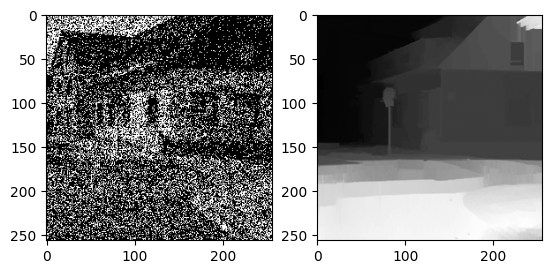

In [4]:
import numpy as np
import utils

idx = np.random.randint(len(ds['train']))
utils.show_images(idx = np.random.randint(len(ds['train'])), ds=ds['train'])

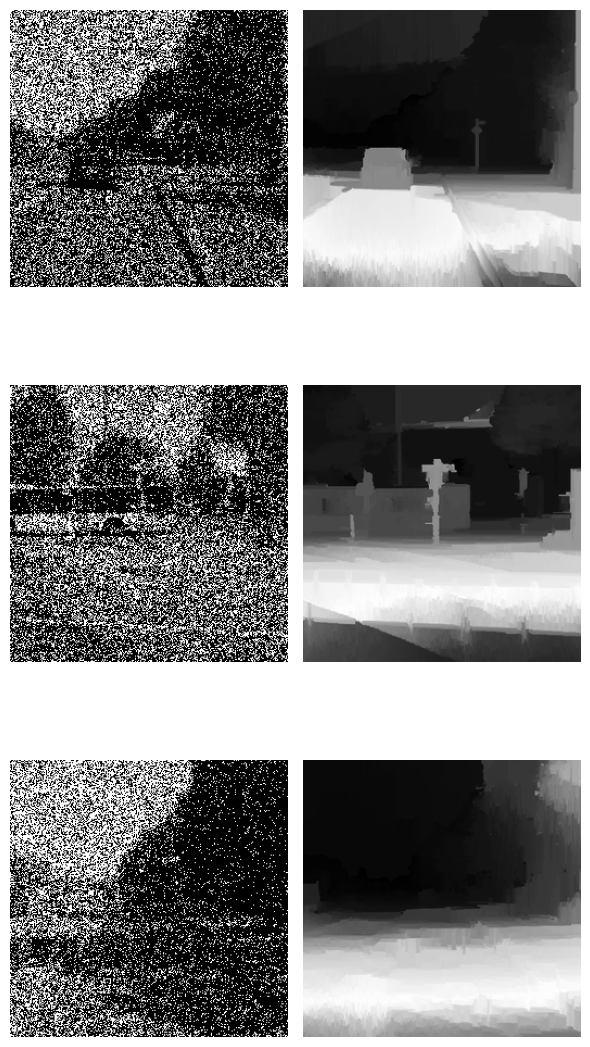

In [ ]:
k = 3
utils.show_random_images(ds['train'],k=k, figsize=(k*2, k*4))

### Model and Other stafs

In [5]:
from importlib import reload
from models.unet import UNet
model = UNet()
model(x).shape
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [23]:
import torch

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

### Training

In [ ]:
from train import train
train(model, optimizer, loss_fn, dl, config, scheduler = None, device = device, use_wandb=False)

### Predictions

In [ ]:
from tqdm import tqdm
import torch
import os
from torchvision.transforms.functional import to_pil_image
from datetime import datetime
from imgs2csv import images_to_csv_with_metadata


def predict(model, dl, device='cpu', dest = 'predictions', use_wandb=False):
    model.to(device)
    model.eval()
    os.makedirs('predictions', exist_ok=True)
    model_name = type(model).__name__+'_'+str(datetime.now())[8:16]
    save_dir = os.path.join('predictions',model_name)
    print(save_dir)
    os.makedirs(save_dir)
    pbar = tqdm(dl,desc=f"Predicting.... ")
    with torch.no_grad():
        for i, (inputs, image_names) in enumerate(pbar):
            inputs = inputs.to(device)
            im_names = [s.split('/')[-1] for s in image_names]
            outputs = model(inputs)
            for x,name in zip(outputs, im_names):
                img = to_pil_image(x)
                img.save(os.path.join(save_dir, name))
            
    

    images_to_csv_with_metadata(save_dir, 'predictions/pred_'+model_name+'.csv')
predict(model, dl['test'], device = device, use_wandb=False)

Predicting.... :   0%|          | 0/84 [00:09<?, ?it/s]

torch.Size([1, 256, 256]) 18053611.png


In [33]:
for x, names in dl['test']:
    print(x.shape, names)
    break
im_names = [s.split('/')[-1] for s in names]

torch.Size([10, 1, 256, 256]) ('./competition-data/testing-images/10852172.png', './competition-data/testing-images/15953191.png', './competition-data/testing-images/14752952.png', './competition-data/testing-images/6251251.png', './competition-data/testing-images/34156832.png', './competition-data/testing-images/24354871.png', './competition-data/testing-images/34656931.png', './competition-data/testing-images/26155231.png', './competition-data/testing-images/10752151.png', './competition-data/testing-images/30956191.png')


In [21]:
np.array(img)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 128, ...,   0,   0,   0],
       ...,
       [  0,   0, 128, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [29]:
from PIL import Image
img = Image.fromarray(x[0].cpu().squeeze(0).numpy(), mode='L')
img.show()

Opening in existing browser session.


In [ ]:
from PIL import Image
import os
dest = 'predictions'
for t, n in zip(x, im_names):
    print(t.shape)
    img = Image.fromarray(t.cpu().squeeze().numpy(), mode='L')
    img.save(os.path.join(dest,n))

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
